In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from tqdm.auto import tqdm

In [3]:
data='/kaggle/input/shoe-dataset/shoeTypeClassifierDataset'

In [34]:
def get_noise(BATCH_SIZE, z_dim, device='cpu'):
    return torch.randn(BATCH_SIZE, z_dim,1,1).to(device) 

In [ ]:
BATCH_SIZE=
LR=
BETAS=(0.5,0.999)
NUM_EPOCHS=
z_dim=200

In [4]:
def visualize_images(path):
    image_filenames = os.listdir(path)
    num_images = min(10, len(image_filenames))
    num_rows = num_images // 5 + (1 if num_images % 5 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]
    
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        if len(image.shape) == 3 and image.shape[2] == 3:  
            image = image.mean(axis=2) 
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(image_filename, fontsize=8)

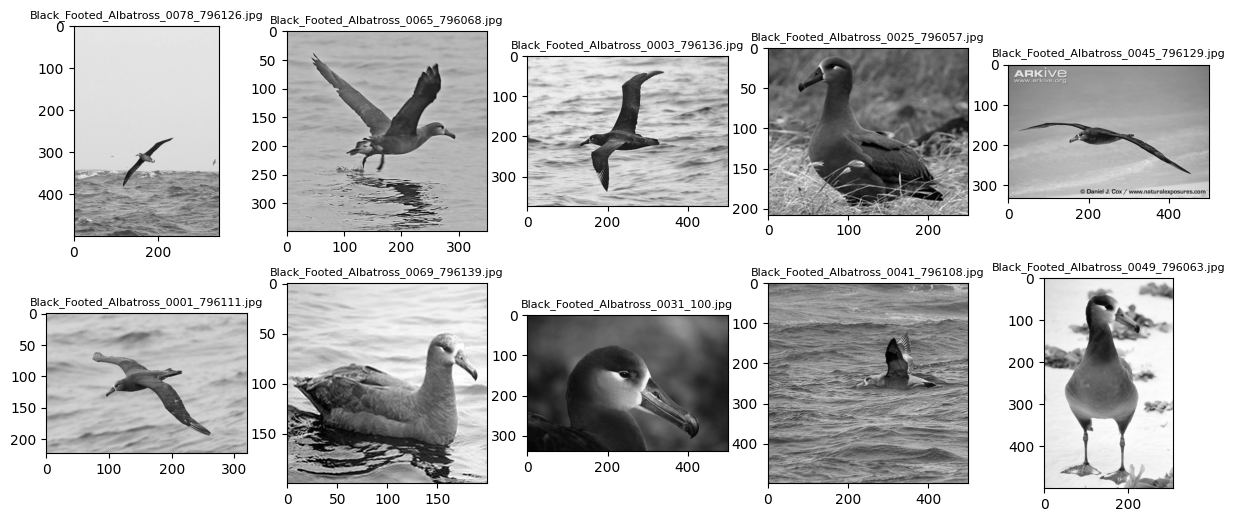

In [5]:
female_dir='/kaggle/input/cub2002011/CUB_200_2011/images/001.Black_footed_Albatross'
visualize_images(female_dir)

In [22]:
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [23]:
train_data='/kaggle/input/cub2002011/CUB_200_2011/images'
# valid_data='/kaggle/input/gender-classification-dataset/Validation'

In [24]:
train_data=datasets.ImageFolder(train_data,transform=transform)

In [27]:
train_data.classes.__len__()

200

In [45]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,Gen=True,drop=False,norm=True,act='relu',kernel_size=3,stride=1,padding=1):
        super(ConvBlock,self).__init__()
        self.drop=drop
        self.norm=norm
        self.Gen=Gen
        self.dropout = nn.Dropout2d(0.5)
        self.act = act
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding) if Gen else nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.BatchNorm2d(out_channels) if norm else nn.Identity(),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        if self.drop:
            x = self.dropout(x)
        return self.block(x)

In [62]:
class Generator(nn.Module):
    def __init__(self,embed_dim=1024,z_dim=100,num_channels=3,hidden_dim=32):
        super(Generator, self).__init__()
        self.linear=nn.Sequential(
            nn.Linear(embed_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv1 = ConvBlock(z_dim,hidden_dim*16,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim*16,hidden_dim*8,Gen=True,drop=False,norm=False,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*8,hidden_dim*4,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*2,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*2,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv6 = ConvBlock(hidden_dim,hidden_dim,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.conv7 = ConvBlock(hidden_dim,num_channels,Gen=True,drop=True,norm=True,act='relu',kernel_size=4,stride=2,padding=1)
        self.tanh=nn.Tanh()
    
    def forward(self,x,label):
        embed=self.linear(label).unsqueeze(2).unsqueeze(2)
        latent_z=torch.cat([embed,x],dim=1)
        x = self.conv1(latent_z)
        print(x.shape) #    torch.Size([1, 512, 2, 2])
        x = self.conv2(x)
        print(x.shape) #    torch.Size([1, 256, 4, 4])
        x = self.conv3(x)
        print(x.shape) #    torch.Size([1, 128, 8, 8])
        x = self.conv4(x)
        print(x.shape) #    torch.Size([1, 64, 16, 16])
        x = self.conv5(x)
        print(x.shape) #    torch.Size([1, 32, 32, 32])
        x = self.conv6(x)
        print(x.shape) #    torch.Size([1, 32, 64, 64])
        x = self.conv7(x)
        print(x.shape) #    torch.Size([1, 3, 128, 128])
        return self.tanh(x)

In [61]:
gen=Generator()

In [54]:
img=get_noise(1,200)
gen(img)

torch.Size([1, 512, 2, 2])
torch.Size([1, 256, 4, 4])
torch.Size([1, 128, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 3, 128, 128])


tensor([[[[0.0000, 0.2190, 0.0000,  ..., 0.0846, 0.0093, 0.1676],
          [0.2471, 0.0000, 0.1882,  ..., 0.1451, 0.1633, 0.0276],
          [0.0000, 0.2494, 0.0000,  ..., 0.2100, 0.0446, 0.1988],
          ...,
          [0.2052, 0.0946, 0.3948,  ..., 0.3003, 0.1081, 0.0252],
          [0.0000, 0.1502, 0.0167,  ..., 0.0797, 0.0000, 0.2049],
          [0.0677, 0.0000, 0.1856,  ..., 0.0000, 0.1092, 0.0000]],

         [[0.0000, 0.0571, 0.0000,  ..., 0.0544, 0.0000, 0.0518],
          [0.0000, 0.2567, 0.0000,  ..., 0.1036, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0712, 0.0000,  ..., 0.0670, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0522,  ..., 0.0000, 0.0269, 0.0000]],

         [[0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2055,  ..., 0

In [ ]:
class Concat_embed(nn.Module):

    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
            nn.BatchNorm1d(num_features=projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat


In [63]:
class Discriminator(nn.Module):
#     embed_dim=1024,z_dim=100,num_channels=3,hidden_dim=32
    def __init__(self,embed_dim=1024,in_channels=3,hidden_dim=64):
        super(Discriminator,self).__init__()
        self.conv1 = ConvBlock(in_channels,hidden_dim,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv2 = ConvBlock(hidden_dim,hidden_dim*2,Gen=False,drop=False,norm=False,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv3 = ConvBlock(hidden_dim*2,hidden_dim*4,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv4 = ConvBlock(hidden_dim*4,hidden_dim*8,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.conv5 = ConvBlock(hidden_dim*8,hidden_dim*16,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv6 = ConvBlock(hidden_dim*16,1,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
#         self.conv7 = ConvBlock(hidden_dim,3,Gen=False,drop=True,norm=True,act='leaky',kernel_size=4,stride=2,padding=1)
        self.projector=nn.Sequential(
            nn.Linear(embed_dim,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2)
        )
        self.conv7=nn.Sequential(
            nn.Conv2d(hidden_dim*16,128,4,2,1),
            nn.Sigmoid()
        )
    
    
    def forward(self,x,embed):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x_intermediate=self.conv5(x)
        x=self.projector(x_intermediate,embed)
        x=self.conv7(x)
        x=x.view(-1,1).squeeze(1)
        return x,x_intermediate

In [57]:
disc=Discriminator()